Climate change is more than a scientific issue — it’s a conversation. People tweet about it every day, expressing concerns, skepticism, hope, and outrage. But what if we could explore those conversations at scale, or even generate new ones?

In [ ]:
import tweepy
import pandas as pd

BEARER_TOKEN = 'YOUR BEARER TOKEN HERE'

client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)

We started by collecting tweets using Twitter’s API, focusing on authentic conversations in English while filtering out retweets to avoid repetition.

In [ ]:
def fetch_tweets(client, query, max_results=100):
    tweets = []
    response = client.search_recent_tweets(
        query=query,
        tweet_fields=["created_at", "public_metrics", "author_id", "text"],
        max_results=max_results
    )
    if response.data:
        for tweet in response.data:
            tweets.append({
                "created_at": tweet.created_at,
                "author_id": tweet.author_id,
                "text": tweet.text,
                "retweets": tweet.public_metrics['retweet_count'],
                "likes": tweet.public_metrics['like_count']
            })
    return pd.DataFrame(tweets)

# Updated query to exclude retweets
query = "climate change lang:en -is:retweet"

tweets_df = fetch_tweets(client, query, max_results=100)

print(tweets_df)

if tweets_df.empty:
    print("No tweets were found for the given query.")

                  created_at            author_id  \
0  2025-04-14 17:59:27+00:00           4830268247   
1  2025-04-14 17:59:27+00:00  1779470086375608320   
2  2025-04-14 17:59:00+00:00           3232649756   
3  2025-04-14 17:58:50+00:00  1769071069384617984   
4  2025-04-14 17:58:50+00:00           1526514464   
..                       ...                  ...   
95 2025-04-14 17:46:46+00:00           3259295526   
96 2025-04-14 17:46:41+00:00  1909025646447034368   
97 2025-04-14 17:46:14+00:00  1779467379237625856   
98 2025-04-14 17:46:07+00:00  1720665183188922368   
99 2025-04-14 17:46:03+00:00  1910403573994631168   

                                                 text  retweets  likes  
0   @si_ad @afneil This has nothing to do with cli...         0      0  
1   The article revealed the causes and consequenc...         0      0  
2   @BreitbartNews I never want to hear a word fro...         0      0  
3   @LightYa90158140 climate change is fake libtar...         0      0 

In [3]:
tweets_df.to_csv("TwitterClimateData.csv", index=False, encoding='utf-8-sig')

We asked GPT-2 to generate 10,000 climate-focused tweets. With carefully crafted prompts and quality filtering, we created synthetic tweets that mimic real-world narratives.

In [ ]:
from transformers import pipeline
import pandas as pd
import random

generator = pipeline("text-generation", model="distilgpt2", tokenizer="distilgpt2", device=device)

# Prompt variations to avoid repetition
prompt_variants = [
    "Climate change is",
    "The effects of climate change are",
    "Scientists say climate change is",
    "We must act because climate change is",
    "Due to climate change,",
    "Experts warn that climate change is",
    "Climate change is a growing concern because",
    "One major issue is climate change",
    "Climate change continues to",
    "The danger of climate change lies in"
]

# Generate tweets in batches with improved speed
def generate_tweets(num_tweets=10000, batch_size=100, max_length=50):
    all_tweets = set()

    while len(all_tweets) < num_tweets:
        prompt = random.choice(prompt_variants)
        print(f"Generating batch {len(all_tweets) // batch_size + 1} with prompt: {prompt}")

        responses = generator(
            prompt,
            max_length=max_length,
            num_return_sequences=batch_size,
            do_sample=True,
            temperature=0.8,
            top_k=40,
            top_p=0.9,
            truncation=True,
            pad_token_id=50256
        )

        for r in responses:
            text = r['generated_text'].strip()

            # Keep only first full sentence
            if "." in text:
                text = text[:text.index(".")+1]
            text = " ".join(text.split())

            # Only include valid and unique tweets
            if len(text) >= 20 and prompt.lower() in text.lower():
                all_tweets.add(text)
    return list(all_tweets)

# Generate tweets
tweets = generate_tweets(num_tweets=10000, batch_size=100)

# Save to CSV
df = pd.DataFrame(tweets, columns=["tweet"])
df.to_csv("synthetic_tweets.csv", index=False)

print("10,000 tweets generated and saved to synthetic_tweets.csv")

Device set to use cpu


Generating batch 1 with prompt: Climate change is
Generating batch 2 with prompt: Climate change continues to
Generating batch 2 with prompt: Scientists say climate change is
Generating batch 3 with prompt: The effects of climate change are
Generating batch 4 with prompt: The effects of climate change are
Generating batch 5 with prompt: Scientists say climate change is
Generating batch 6 with prompt: The danger of climate change lies in
Generating batch 7 with prompt: The danger of climate change lies in
Generating batch 8 with prompt: The danger of climate change lies in
Generating batch 9 with prompt: Experts warn that climate change is
Generating batch 10 with prompt: Due to climate change,
Generating batch 11 with prompt: Climate change is a growing concern because
Generating batch 12 with prompt: One major issue is climate change
Generating batch 12 with prompt: Climate change is
Generating batch 13 with prompt: Climate change continues to
Generating batch 14 with prompt: Climate 

**Word Cloud**

This WordCloud highlights the most frequently used words in climate-related tweets, giving quick insights into common topics like climate change, risk, ecosystem, hoax, and more.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# clean tweet text
def clean_text(text):
    text = re.sub(r"http\S+|@\S+|#\S+", "", str(text))  # remove links, mentions, hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # remove punctuation
    return text.lower().strip()

# generate WordCloud
def generate_word_cloud(df, column='text', title="Word Cloud for Climate Tweets"):
    # Clean text if not already cleaned
    if 'cleaned' not in df.columns:
        df['cleaned'] = df[column].dropna().apply(clean_text)

    # Combine all cleaned text
    cleaned_text = " ".join(df['cleaned'].tolist())

    # Generate WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=True  # keep meaningful word pairs
    ).generate(cleaned_text)

    # Plot WordCloud
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

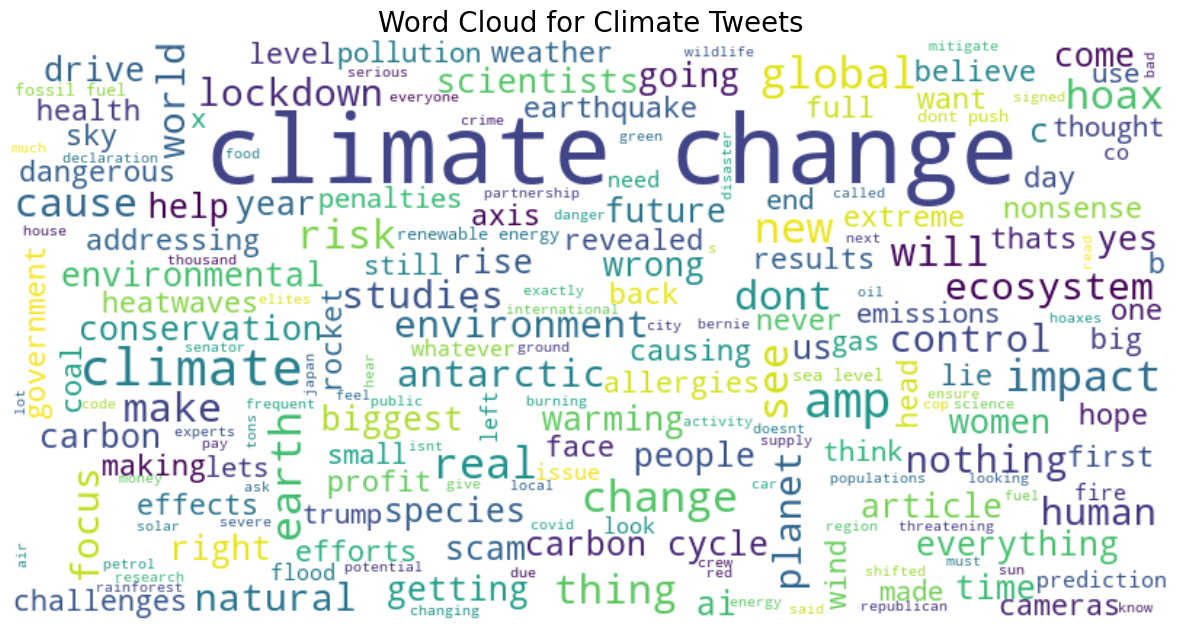

In [ ]:
# Load your dataset
df = pd.read_csv("synthetic_tweets.csv")

# Generate the WordCloud
generate_word_cloud(df, column='text', title="Word Cloud for Climate Tweets")

Observations:

- The most prominent terms include "climate", "change", "earth", "risk", "environment", "carbon", and "ecosystem".

- Words like “scam”, “hoax”, and “fear” suggest that a portion of tweets express skepticism or misinformation about climate change.

- On the other hand, terms like “conservation”, “species”, “emissions”, and “renewable” reflect awareness and activism.

- Mentions of political figures (e.g., "trump"), and terms like “government” and “profit” imply public discourse around climate policy and economics.

- Words like "lockdown", "allergies", and "health" indicate a cross-topic overlap with COVID-19 and environmental health concerns.

Insight:

The WordCloud reveals that Twitter discussions around climate change are not just scientific or environmental, but deeply intertwined with politics, misinformation, health, and activism.

**Sentiment Analysis**

This histogram represents the polarity scores of the tweets using TextBlob. Most tweets hover around neutral (0), with a slight skew toward positivity, indicating a balanced discussion with mixed sentiments.

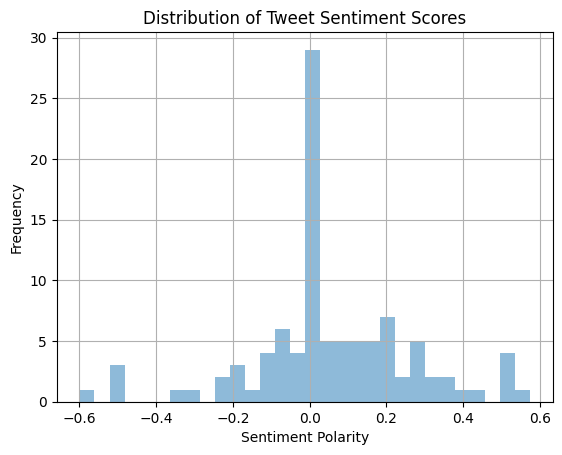

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# Load your tweet dataset
df = pd.read_csv("Twitter_Climate_Data.csv")

# Make a copy for sentiment analysis
df_sentiment = df.copy()

# Apply sentiment analysis to the 'text' column
df_sentiment['Sentiment'] = df_sentiment['text'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else 0.0
)

# Plot histogram of sentiment polarity scores
df_sentiment['Sentiment'].hist(bins=30, alpha=0.5)
plt.title("Distribution of Tweet Sentiment Scores")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Observations:

- The sentiment polarity is centered around 0, showing a large number of neutral tweets.

- A moderate number of tweets exhibit positive sentiment (polarity > 0), likely discussing solutions, innovations, or hopeful outlooks.

- Some tweets fall into the negative sentiment zone (polarity < 0), possibly reflecting anxiety, criticism, or climate skepticism.

Insight:

Twitter discourse on climate change is largely neutral, but skewed slightly positive, indicating a cautious optimism in the community. The presence of negative sentiments reflects concern, frustration, or misinformation.

**Emotion Analysis**

This bar chart displays the total emotional weight of tweets based on NRC lexicon. The leading emotion is fear, followed by positive, negative, and trust, reflecting public concern and urgency around climate change topics.

In [4]:
from nrclex import NRCLex
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

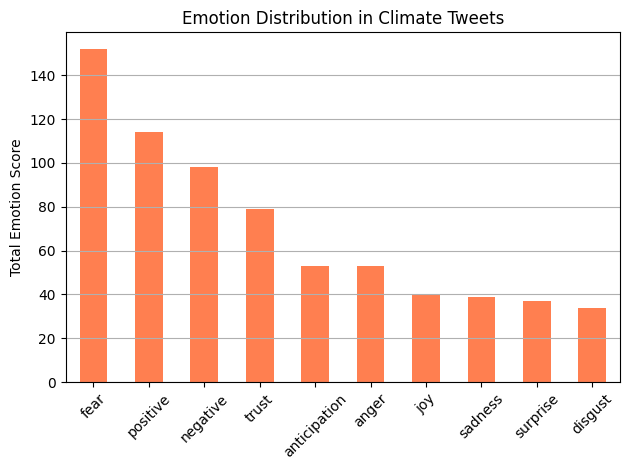

In [ ]:
# Load the dataset
df = pd.read_csv("Twitter_Climate_Data.csv")

# Create a working copy
df_emotion = df.copy()

# Ensure 'text' column is string type
df_emotion['text'] = df_emotion['text'].astype(str)

# Extract raw emotion scores using NRCLex
df_emotion['Emotions'] = df_emotion['text'].apply(lambda x: NRCLex(x).raw_emotion_scores)

# Convert to a DataFrame of emotion counts
emotion_counts = pd.DataFrame(df_emotion['Emotions'].tolist()).fillna(0).sum().sort_values(ascending=False)

# Plot emotion distribution
emotion_counts.plot(kind='bar', color='coral')
plt.title("Emotion Distribution in Climate Tweets")
plt.ylabel("Total Emotion Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Observations:

- Fear is the most dominant emotion, aligning with the public’s anxiety over climate consequences.

- Surprisingly, positive emotions rank second, followed by negative and trust, suggesting a duality of concern and hope.

- Emotions like anticipation and joy are present, indicating expectancy or engagement in climate solutions.

- Anger, sadness, and disgust appear but are less dominant, reflecting less hostility but noticeable frustration.

Insight:

The emotion landscape shows that climate discussions are emotionally rich, driven by fear, but balanced with trust, hope, and anticipation. This suggests that users are not just fearful, but also engaged and optimistic about change.